# Baseline Model

## Table of Contents
1. [Model Choice](#model-choice)
2. [Feature Selection](#feature-selection)
3. [Implementation](#implementation)
4. [Evaluation](#evaluation)


## Model Choice

As a baseline modell a simple regression modell is mostly a good starting point. A appropriate modell for a classification problem is logistic regression, which I will use in the following.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
import warnings

warnings.filterwarnings('ignore')


## Feature Selection
The features will be the different activities. The train dataset will be based on the first 7 people in the datset whereas the test dataset will be the last of the 8 different people who gathered data. Download with Colab:

In [ ]:
# connect to google drive
from google.colab import drive
import pandas as pd

# mount on google drive
drive.mount('/content/drive')
# unzip
!unzip /content/drive/MyDrive/archive.zip
# import into dataset
df = pd.read_csv('/content/dataset2.csv', engine ='pyarrow')

Import locally:

In [5]:
# download 
df = pd.read_csv('/home/tomruge/Schreibtisch/UNI/Semester_7/machine_learning_with_tensorflow/archive_physical_activity.csv', engine='pyarrow')

In [6]:
from sklearn.preprocessing import LabelEncoder

# apply undersampling. sample down to size of smallest class
df = df.groupby('activityID').apply(lambda x: x.sample(df['activityID'].value_counts().min())).reset_index(drop=True)

# Drop all rows with NaN values
df.dropna(inplace=True)

# Mask for train and test split
mask = (df['PeopleId'] == 8)

# Use LabelEncoder to automatically assign numerical values to classes
label_encoder = LabelEncoder()
df['activityID'] = label_encoder.fit_transform(df['activityID'])

# Print the mapping of original class labels to numerical labels
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label Mapping:", label_mapping)

y_train = df['activityID'][~mask]
X_train = df.drop(['activityID'], axis=1, inplace = False)[~mask]

y_test = df['activityID'][mask]
X_test = df.drop(['activityID'], axis=1, inplace = False)[mask]

Label Mapping: {'Nordic walking': 0, 'ascending stairs': 1, 'cycling': 2, 'descending stairs': 3, 'ironing': 4, 'lying': 5, 'rope jumping': 6, 'running': 7, 'sitting': 8, 'standing': 9, 'transient activities': 10, 'vacuum cleaning': 11, 'walking': 12}


## Implementation

Logistic regression:


In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import copy
import seaborn as sns
import matplotlib.pyplot as plt
# Load the dataset
df = pd.read_csv('/home/tomruge/Schreibtisch/UNI/Semester_7/machine_learning_with_tensorflow/archive_physical_activity.csv', engine='pyarrow')
# Drop all rows with NaN values
df.dropna(inplace=True)
# undersampling

def perform_random_undersampling(df, target_column, minority_class = 'rope jumping'):
    minority_class_len = len(df[df[target_column] == minority_class])
    indices = []
    for i in np.unique(df[target_column]):
        indices.extend(np.random.choice(df[df[target_column] == i].index, minority_class_len, replace=False))
    indices_sort = np.sort(indices)
    return df.loc[indices_sort]

df = perform_random_undersampling(df, 'activityID')

# Use LabelEncoder to automatically assign numerical values to classes
label_encoder = LabelEncoder()
df['activityID'] = label_encoder.fit_transform(df['activityID'])

models = []
y_tests = []
X_tests = []

for i in range(1,9):  # Assuming you have 10 unique PeopleId
    print('peopleID_mask: ', i, ' of 9')
    # Mask for train and test split
    work_df = copy.deepcopy(df)  # Use deepcopy to avoid unintended mutation
    
    mask = (work_df['PeopleId'] == i)

    # Print the mapping of original class labels to numerical labels
    label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

    # Extract training data
    y_train = work_df['activityID'][~mask]
    X_train = work_df.drop(['activityID'], axis=1, inplace = False)[~mask]

    # Extract testing data
    y_test = work_df['activityID'][mask]
    X_test = work_df.drop(['activityID'], axis=1, inplace = False)[mask]



    # Standardize the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Create and train the logistic regression model
    model = LogisticRegression(multi_class='multinomial', max_iter=100000)
    model.fit(X_train_scaled, y_train)
    
    models.append(copy.deepcopy(model))
    y_tests.append(copy.deepcopy(y_test))
    X_tests.append(copy.deepcopy(X_test_scaled))

# Perform evaluations or further analysis as needed using the models, y_tests, and X_tests.


peopleID_mask:  1  of 9
peopleID_mask:  2  of 9
peopleID_mask:  3  of 9
peopleID_mask:  4  of 9
peopleID_mask:  5  of 9
peopleID_mask:  6  of 9
peopleID_mask:  7  of 9
peopleID_mask:  8  of 9


## Evaluation

My metrics will be: $$ Accuracy = \frac{Number\ of\ Correct\ Predictions}{Total\ Number\ of\ Predictions}$$


In [8]:
from sklearn.metrics import accuracy_score, classification_report
import numpy as np  # Assuming you might need numpy

# Assuming you have already defined models, X_tests, and y_tests

y_pred_labels_list = []
accuracy_list = []
for i in range(8):
    print("Test_PeopleID_mask:", i+1)
    
    # Make predictions on the test set using the i-th model
    y_pred = models[i].predict(X_tests[i])

    # Evaluate the model
    accuracy = accuracy_score(y_tests[i], y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Display classification report
    print(classification_report(y_tests[i], y_pred))
    
    y_pred_labels_list.append(y_pred)

    # Check if all entries in y_tests and y_pred_labels_list are the same
    unique_values_y_tests = set(y_tests[i])
    unique_values_y_pred = set(y_pred_labels_list[i])
    
    # Check if all values match
    match_all = np.array_equal(y_tests[i], y_pred_labels_list[i])
    print(f"All values match: {match_all}")
    accuracy_list.append(accuracy)
    print("-" * 40)

print(f"Average accuracy: {np.mean(accuracy_list):.2f}")
print(f"Standard deviation: {np.std(accuracy_list):.2f}")

Test_PeopleID_mask: 1
Accuracy: 0.44
              precision    recall  f1-score   support

           0       0.54      0.37      0.44      4651
           1       0.43      0.73      0.54      5899
           2       0.96      0.94      0.95      6176
           3       0.35      0.76      0.48      6189
           4       0.30      1.00      0.46      4250
           5       0.82      0.78      0.80      6114
           6       0.18      0.13      0.15     12912
           7       0.30      0.39      0.34      9350
           8       0.00      0.00      0.00      5537
           9       0.00      0.00      0.00      4925
          10       0.48      0.07      0.11      5885
          11       0.99      0.63      0.77      5642
          12       0.71      0.21      0.33      4017

    accuracy                           0.44     81547
   macro avg       0.47      0.46      0.41     81547
weighted avg       0.44      0.44      0.40     81547

All values match: False
------------------

Confusion matrix:

Test_PeopleID_mask: 1


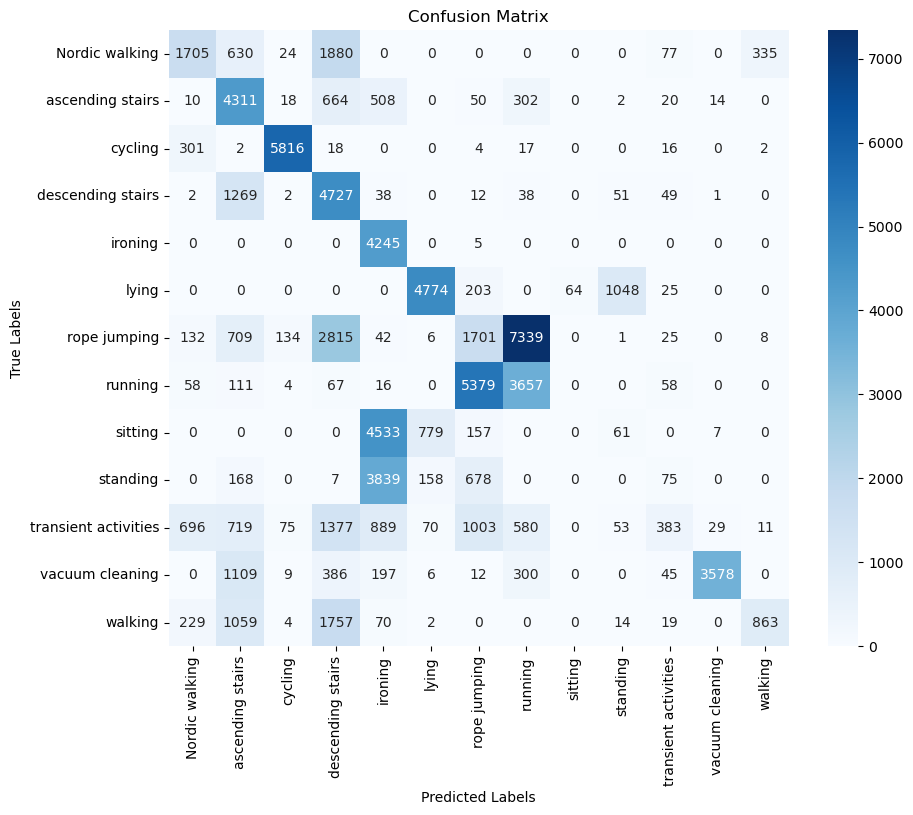

Test_PeopleID_mask: 2


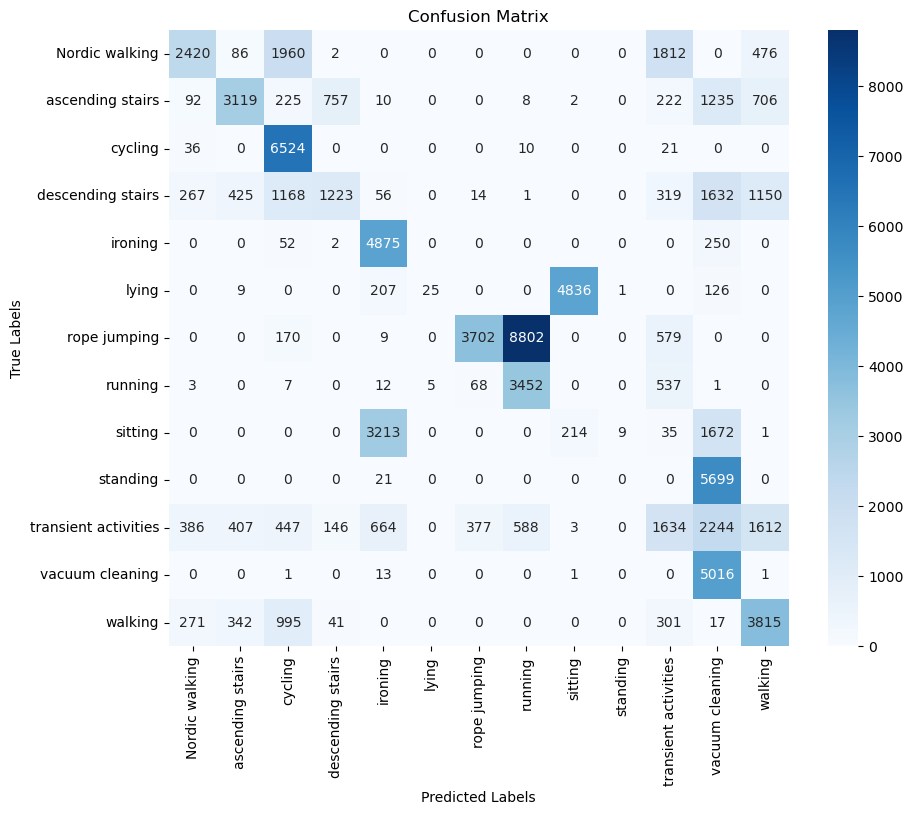

Test_PeopleID_mask: 3


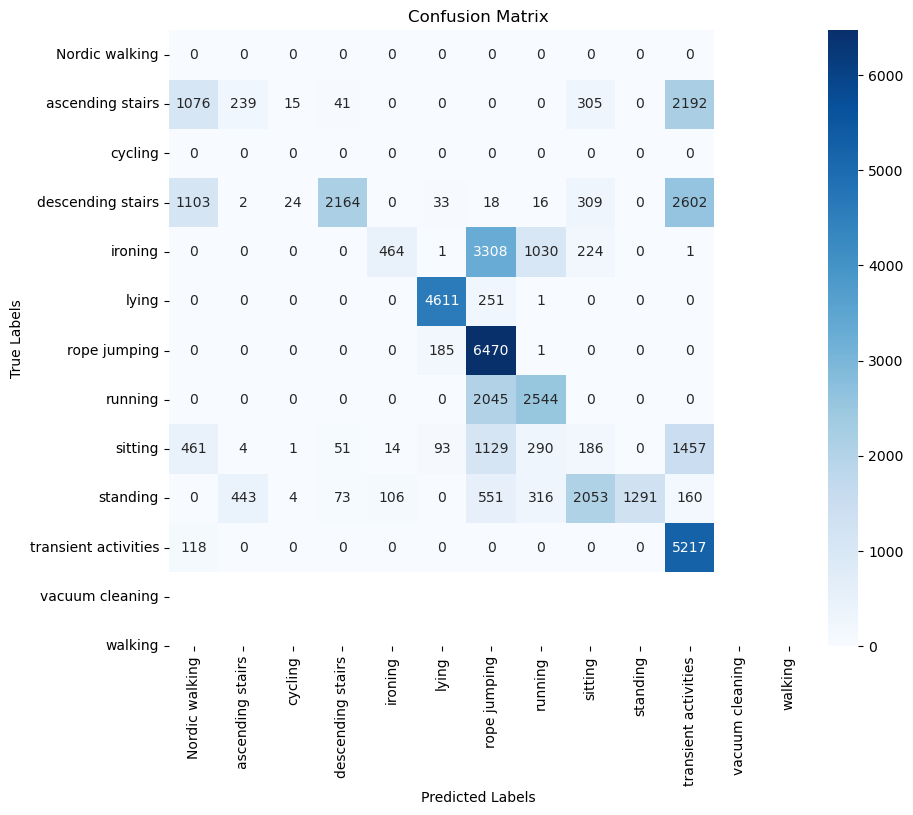

Test_PeopleID_mask: 4


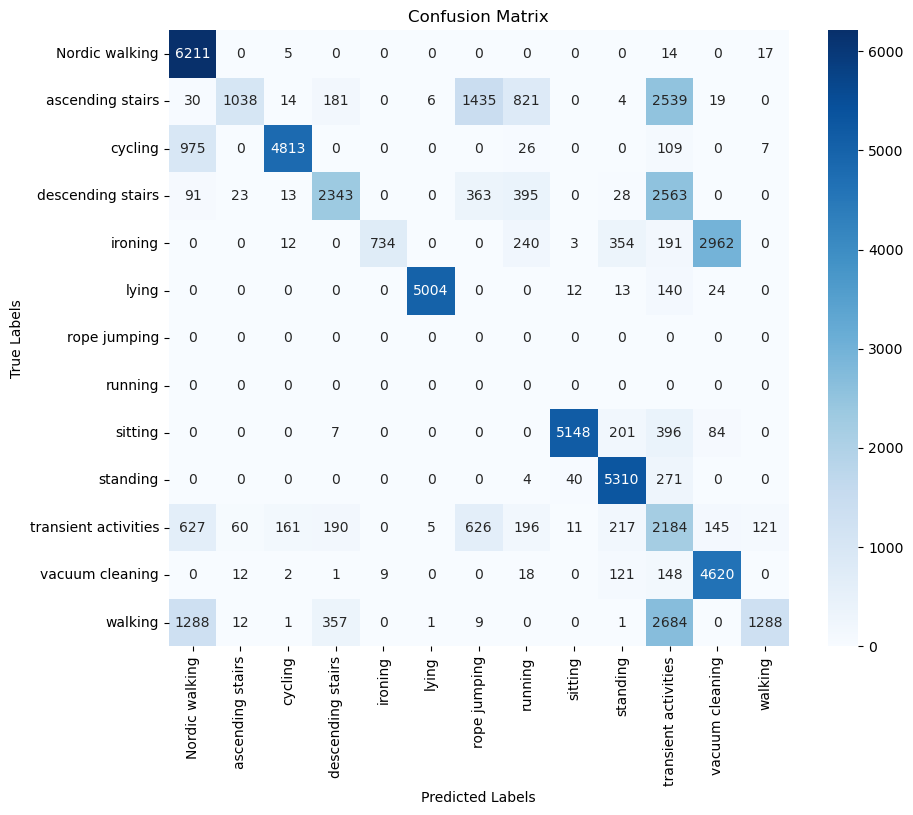

Test_PeopleID_mask: 5


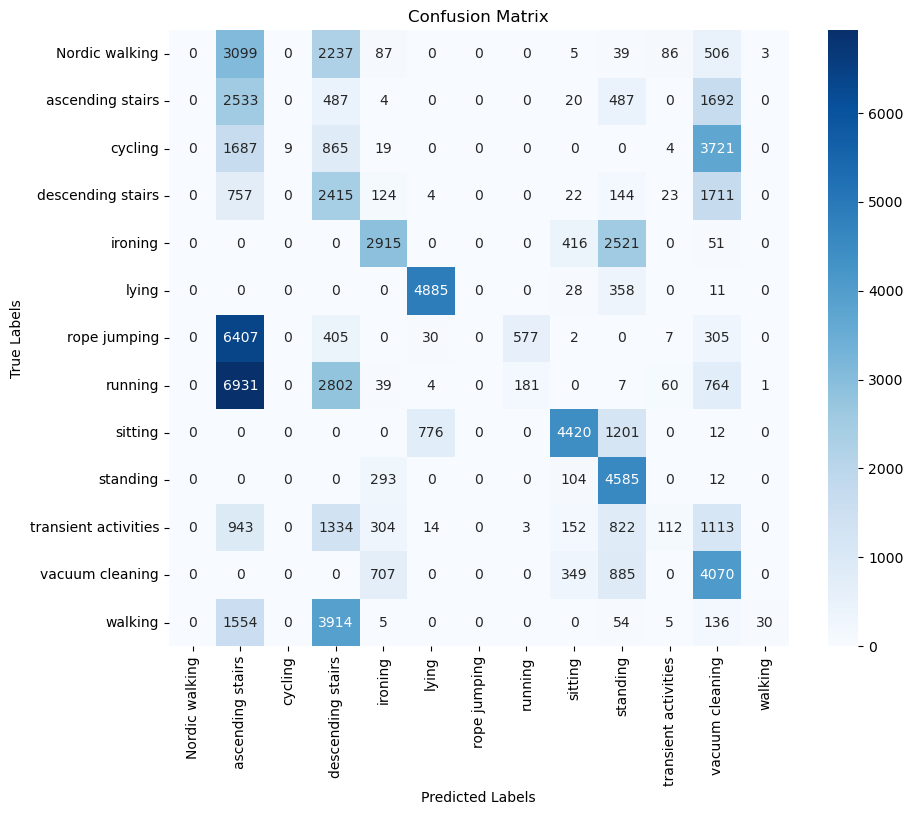

Test_PeopleID_mask: 6


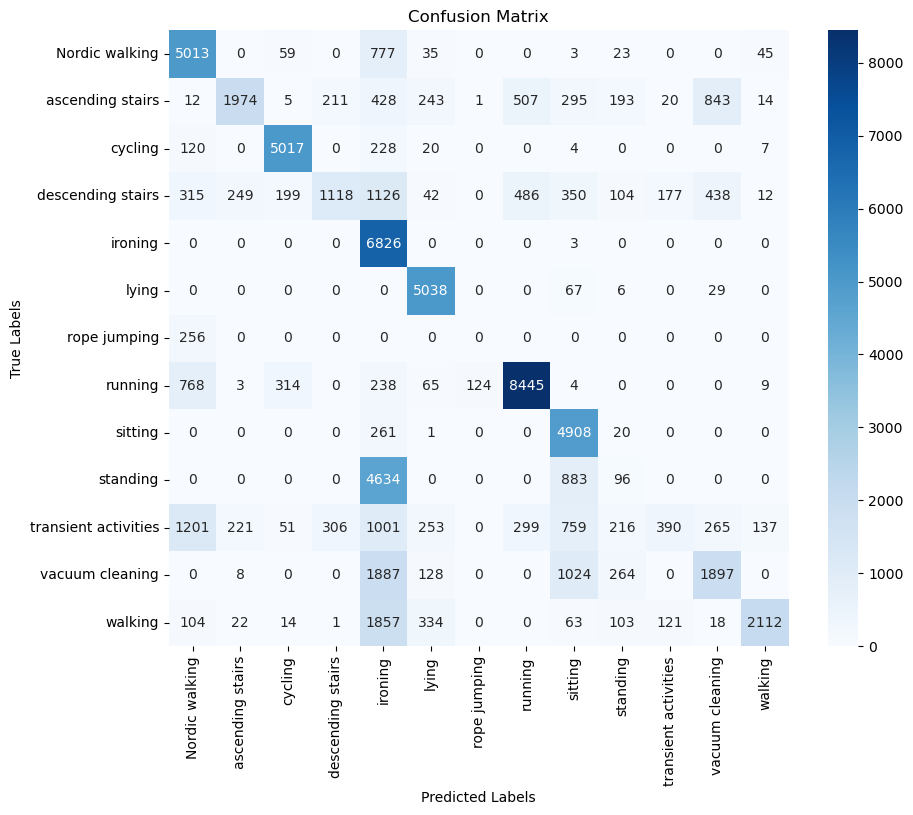

Test_PeopleID_mask: 7


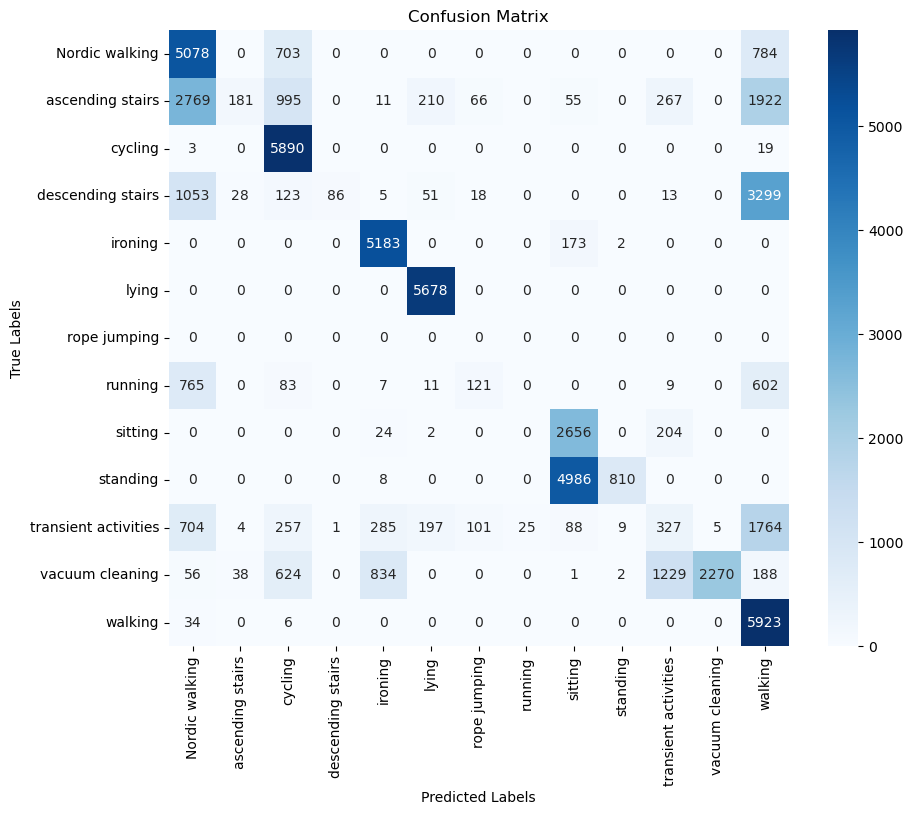

Test_PeopleID_mask: 8


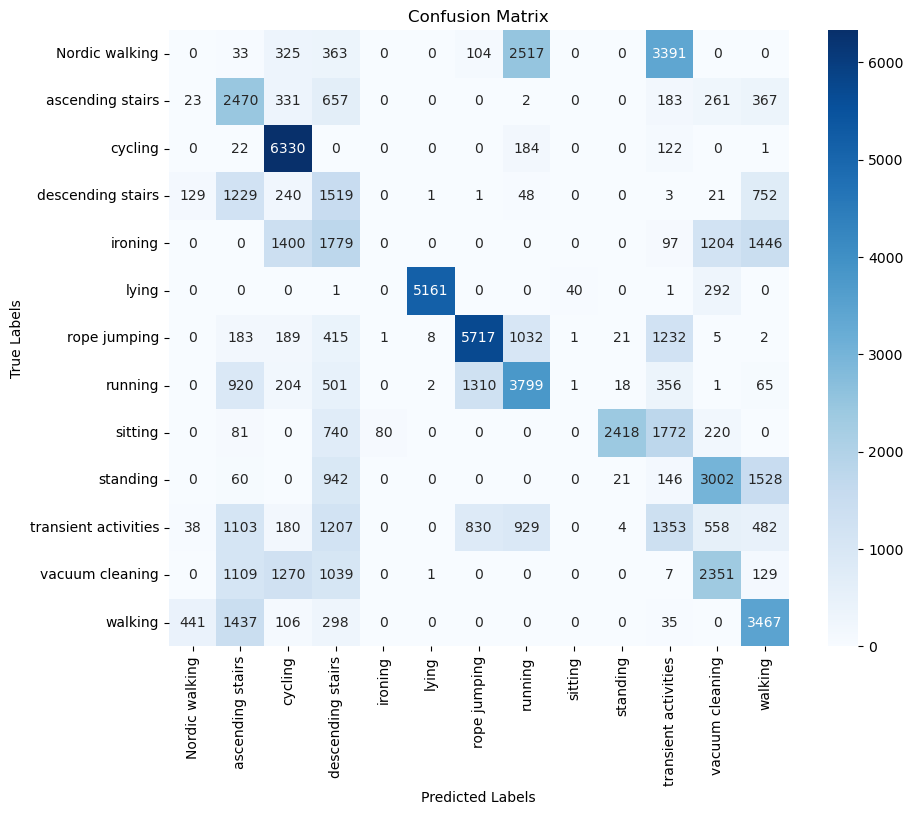

In [9]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


for i in range(8):
    print("Test_PeopleID_mask:", i+1)
    
    # Calculate the confusion matrix
    conf_matrix = confusion_matrix(y_tests[i], y_pred_labels_list[i])

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.keys(), yticklabels=label_mapping.keys())
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


As expected the modell is confused by transient activities, since they are not well defined and have a big deviation within itself. Also activities which can be seen related like sitting and lying got confused very often. But for a first modell not that bad.